### Time Series Forecasting using LSTM

Problem Statement : Predicting temperature using weather data from Max plank Institute using univariate(Single feature as temperature) and mutlivariate(using pressure, temperature and density) as features.

Data Link :# data source: Max Plank Institute, https://www.bgc-jena.mpg.de/wetter/


In [0]:
# Importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False



In [0]:
### get data from Max plank URL using tf utils

zip_path = tf.keras.utils.get_file(origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip' , fname='jena_climate_2009_2016.csv.zip', extract=True)
print(zip_path)

csv_path = os.path.splitext(zip_path)

print(csv_path)

/root/.keras/datasets/jena_climate_2009_2016.csv.zip
('/root/.keras/datasets/jena_climate_2009_2016.csv', '.zip')


In [0]:
! ls /root/.keras/datasets/

jena_climate_2009_2016.csv  jena_climate_2009_2016.csv.zip


In [0]:
### create a dataframe from downloaded csv file
import zipfile

zf = zipfile.ZipFile(zip_path)
df = pd.read_csv(zf.open('jena_climate_2009_2016.csv'))

df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Observations:
1) One reading evrry 10 mins (from datatime column time diff for every record )
2) 1day = 6*24 = 144 readings
Task : Forecasting Temperature(in degree ) in future 




In [0]:
## using univariate feature(Only temperature for given time)

uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

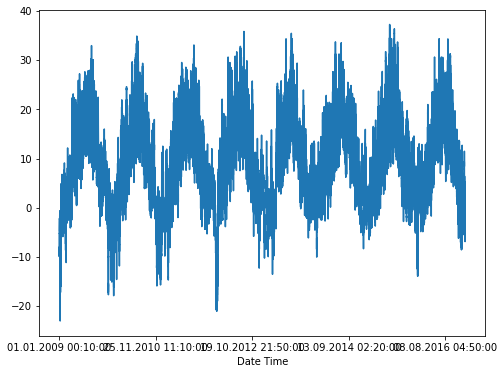

In [0]:
uni_data.plot()

In [0]:
uni_data = uni_data.values

In [0]:
## train test split for simple time series moving window average
train_split = 300000
tf.random.set_seed(13)

### standardize data
uni_data_mean = uni_data[:train_split].mean()
uni_data_std = uni_data[:train_split].std()
uni_data  = (uni_data - uni_data_mean)/ uni_data_std

print(type(uni_data))


<class 'numpy.ndarray'>


Moving Window Average


1.   Given last 20 values of observations(temp) , predict next observation
2.   MWA: predict== AVG(last 20 values)




In [0]:
## utility functions

## funtion to create data for univariate forecasting

def univariate_data(dataset, start_idx , end_idx , history_size, target_size):
  data = []
  labels = []
  start_idx  = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx):
    idxs = range(i-history_size , i)
    data.append(np.reshape(dataset[idxs] , (history_size, 1))) ### reshape data
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

uni_data_history = 20   ## last 20 values
uni_data_future = 0     ## future data

x_train_uni , y_train_uni = univariate_data(uni_data , 0 , train_split , uni_data_history , uni_data_future)

x_val_uni , y_val_uni = univariate_data(uni_data , train_split , None ,uni_data_history , uni_data_future)

In [49]:
print(x_train_uni.shape , y_train_uni.shape)
print(x_val_uni.shape , y_val_uni.shape)

(299980, 20, 1) (299980,)
(120531, 20, 1) (120531,)


In [50]:
print('Single window of history data' , x_train_uni[0])

print('Target Temperature to predict ' , y_train_uni[0])


Single window of history data [[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]
Target Temperature to predict  -2.1041848598100876


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

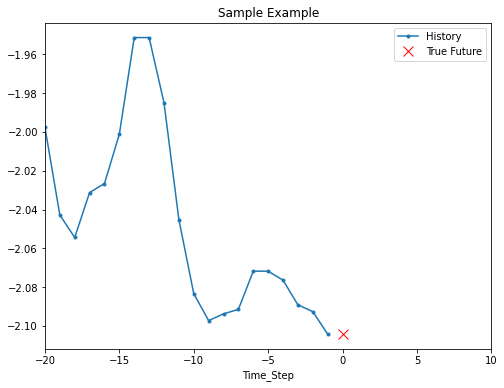

In [52]:
### fucntion to create time steps
def create_time_steps(length):
  return list(range(-length,0))

### function to plot time series data

def plot_time_series(plot_data, delta , title):
  labels = ["History" , 'True Future' , 'Model Predcited']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt

plot_time_series([x_train_uni[0] , y_train_uni[0]] , 0 , 'Sample Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

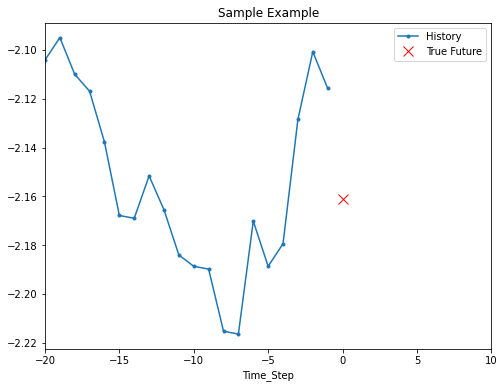

In [56]:
i = 20
plot_time_series([x_train_uni[i], y_train_uni[i]] , 0 , 'Sample Example')

In [0]:
### Moving window average

def MWA(history):
  return np.mean(history)




<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

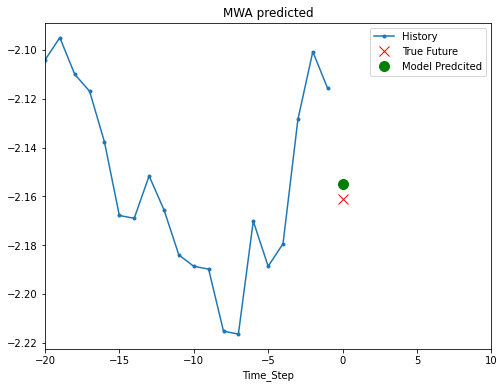

In [59]:
i = 20
plot_time_series([x_train_uni[i] , y_train_uni[i] , MWA(x_train_uni[i])] , 0 , 'MWA predicted')

Univariate time-series forecasting


*   Only single feature as temperature(historical data)
*   Task:  Given last 20 observations(history) , predict next temperature value 



In [60]:
## prepare tensorflow dataset
batch_size = 256
buffer_size = 10000

train_uni = tf.data.Dataset.from_tensor_slices((x_train_uni , y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni = tf.data.Dataset.from_tensor_slices((x_val_uni , y_val_uni))
val_uni = val_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_uni)
print(val_uni)

<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>


In [61]:
## Define LSTM model 

lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(16 , input_shape = x_train_uni.shape[-2:]), 
                                         tf.keras.layers.Dense(1)])

lstm_model.compile(optimizer = 'adam', loss = 'mae')

steps = 200

EPOCHS =10

lstm_model.fit(train_uni , epochs = EPOCHS, steps_per_epoch = steps ,
               validation_data = val_uni, validation_steps = 50)



Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1597 - val_loss: 0.0306
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0397 - val_loss: 0.0247
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0325 - val_loss: 0.0226
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0289 - val_loss: 0.0199
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0223 - val_loss: 0.0183
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0243 - val_loss: 0.0177
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0223 - val_loss: 0.0164
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0209 - val_loss: 0.0170
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0204 - val_loss: 0.0147
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0188 - val_lo

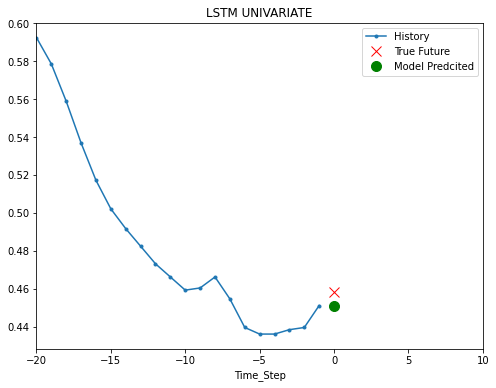

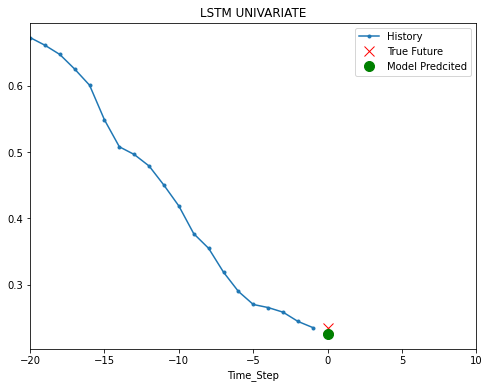

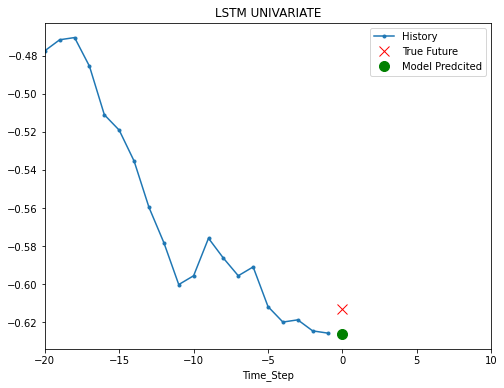

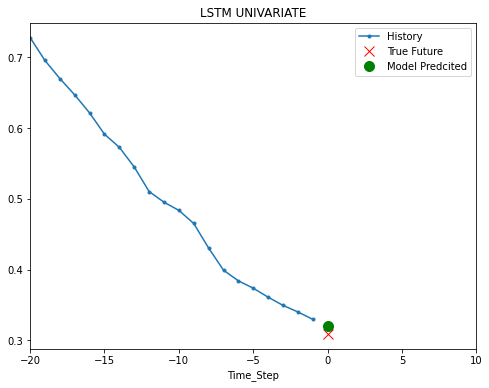

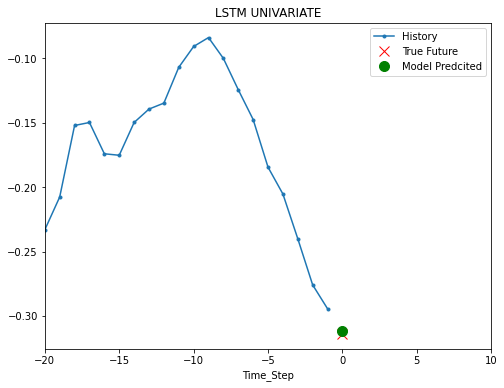

In [62]:
for i , j in val_uni.take(5):
  plot = plot_time_series([i[0].numpy() , j[0].numpy() , lstm_model.predict(i)[0]] ,0 , 'LSTM UNIVARIATE')
  plot.show()

Multivariate  and Single step Forecasting


*   Task: Given 3 features(temp , pressure , and density) at each time step can we predict the temp in future at single time step




In [63]:
## features 

features_3 = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_3]
features.index = df['Date Time']
features.head()


,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc648d9cc0>,
      dtype=object)

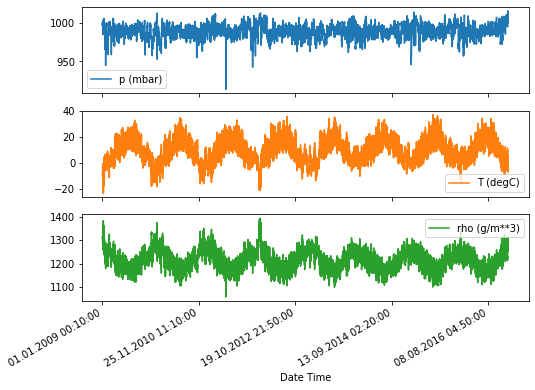

In [65]:
features.plot(subplots=True)

In [0]:
### standardize data
dataset = features.values

data_mean = dataset[:train_split].mean(axis =0)

data_std = dataset[:train_split].std(axis = 0)

dataset = (dataset - data_mean)/data_std



In [0]:
### create mutlivariate data

def mutlivariate_data(dataset , target , start_idx , end_idx , history_size , target_size,
                      step ,  single_step = False):
  data = []
  labels = []
  start_idx = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx ):
    idxs = range(i-history_size, i, step) ### using step
    data.append(dataset[idxs])
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data) , np.array(labels)



In [71]:
### generate multivariate data

history = 720
future_target = 72
STEP = 6

x_train_ss , y_train_ss = mutlivariate_data(dataset , dataset[:, 1], 0, train_split, history,
                                            future_target, STEP , single_step = True)

x_val_ss , y_val_ss = mutlivariate_data(dataset , dataset[:,1] , train_split , None , history ,
                                        future_target, STEP, single_step = True)

print(x_train_ss.shape , y_train_ss.shape)

(299280, 120, 3) (299280,)


In [73]:
## tensorflow dataset

train_ss = tf.data.Dataset.from_tensor_slices((x_train_ss, y_train_ss))
train_ss = train_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_ss = tf.data.Dataset.from_tensor_slices((x_val_ss, y_val_ss))
val_ss = val_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_ss)
print(val_ss)



<RepeatDataset shapes: ((None, 120, 3), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 120, 3), (None,)), types: (tf.float64, tf.float64)>


In [76]:
### Modelling using LSTM

single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(32, input_shape = x_train_ss.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mae')
single_step_model_history = single_step_model.fit(train_ss, epochs = EPOCHS , 
                                                  steps_per_epoch =steps, validation_data = val_ss,
                                                  validation_steps = 50)


Epoch 1/10
200/200 [==============================] - 23s 115ms/step - loss: 0.3477 - val_loss: 0.2667
Epoch 2/10
200/200 [==============================] - 21s 105ms/step - loss: 0.2699 - val_loss: 0.2616
Epoch 3/10
200/200 [==============================] - 21s 104ms/step - loss: 0.2655 - val_loss: 0.2678
Epoch 4/10
200/200 [==============================] - 22s 111ms/step - loss: 0.2616 - val_loss: 0.2466
Epoch 5/10
200/200 [==============================] - 22s 108ms/step - loss: 0.2288 - val_loss: 0.2433
Epoch 6/10
200/200 [==============================] - 21s 107ms/step - loss: 0.2463 - val_loss: 0.2724
Epoch 7/10
200/200 [==============================] - 23s 113ms/step - loss: 0.2439 - val_loss: 0.2649
Epoch 8/10
200/200 [==============================] - 23s 113ms/step - loss: 0.2455 - val_loss: 0.2582
Epoch 9/10
200/200 [==============================] - 23s 115ms/step - loss: 0.2501 - val_loss: 0.2514
Epoch 10/10
200/200 [==============================] - 23s 116ms/step - l

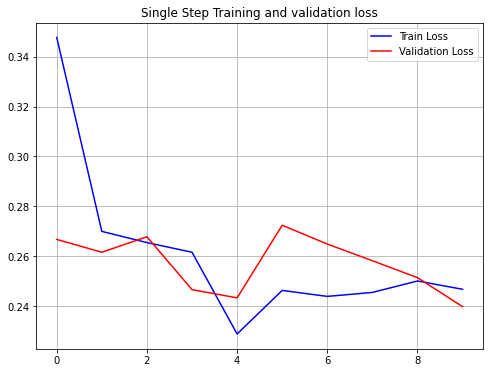

In [79]:
## plot train test loss 

def plot_loss(history , title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss , 'b' , label = 'Train Loss')
  plt.plot(epochs, val_loss , 'r' , label = 'Validation Loss')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()

plot_loss(single_step_model_history , 'Single Step Training and validation loss')

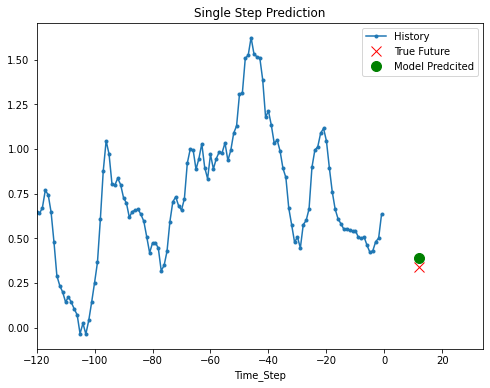

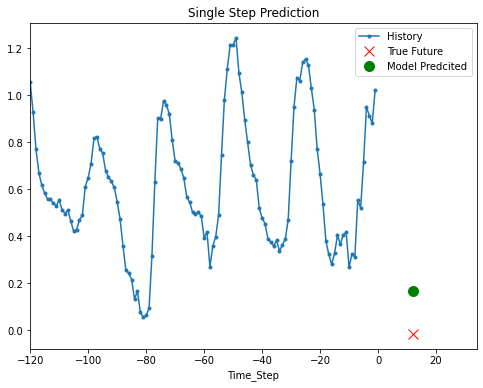

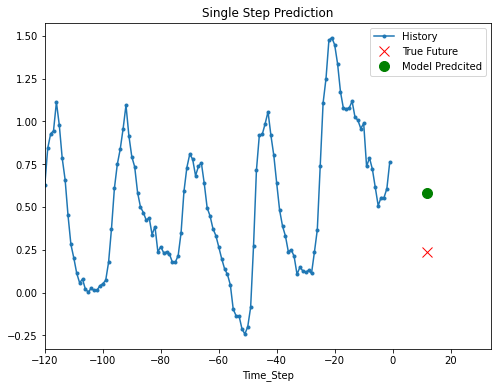

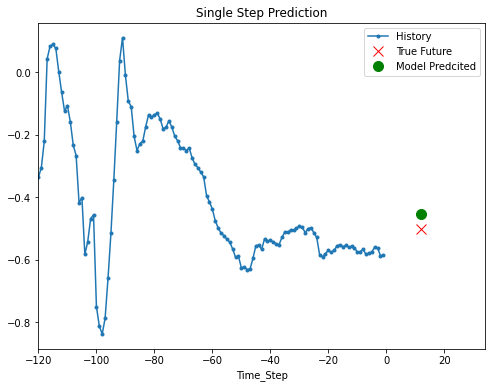

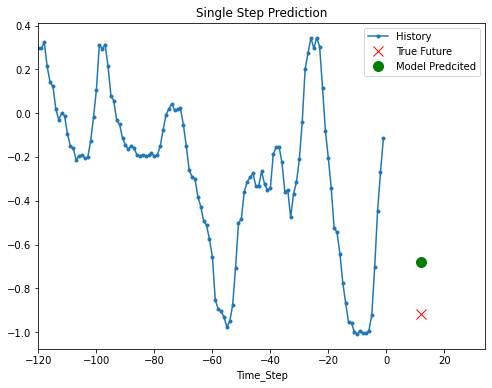

In [80]:
# plot time series and predicted values

for x, y in val_ss.take(5):
  plot = plot_time_series([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

Multi-variate & multi-step forecasting
-> Generate multiple future values of temperature

In [82]:
future_target = 72 # 72 future values
x_train_multi, y_train_multi = mutlivariate_data(dataset, dataset[:, 1], 0,
                                                 train_split, history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = mutlivariate_data(dataset, dataset[:, 1],
                                             train_split, None, history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)

(299280, 120, 3)
(299280, 72)


In [0]:
# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

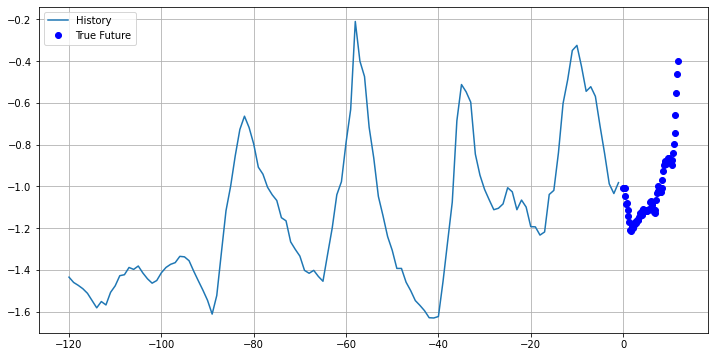

In [84]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [87]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=steps,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 35s 175ms/step - loss: 3.2117 - val_loss: 9.9011
Epoch 2/10
200/200 [==============================] - 35s 177ms/step - loss: 3.4200 - val_loss: 0.3197
Epoch 3/10
200/200 [==============================] - 37s 186ms/step - loss: 0.3667 - val_loss: 0.2787
Epoch 4/10
200/200 [==============================] - 38s 189ms/step - loss: 0.2838 - val_loss: 0.2421
Epoch 5/10
200/200 [==============================] - 37s 186ms/step - loss: 0.2195 - val_loss: 0.2178
Epoch 6/10
200/200 [==============================] - 38s 191ms/step - loss: 0.2201 - val_loss: 0.2220
Epoch 7/10
200/200 [==============================] - 38s 191ms/step - loss: 0.2063 - val_loss: 0.2126
Epoch 8/10
200/200 [==============================] - 38s 191ms/step - loss: 0.2015 - val_loss: 0.1954
Epoch 9/10
200/200 [==============================] - 38s 190ms/step - loss: 0.2030 - val_loss: 0.1911
Epoch 10/10
200/200 [==============================] - 39s 193ms/step - l

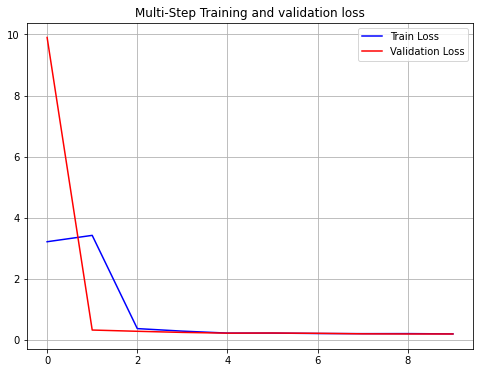

In [88]:
plot_loss(multi_step_history, 'Multi-Step Training and validation loss')


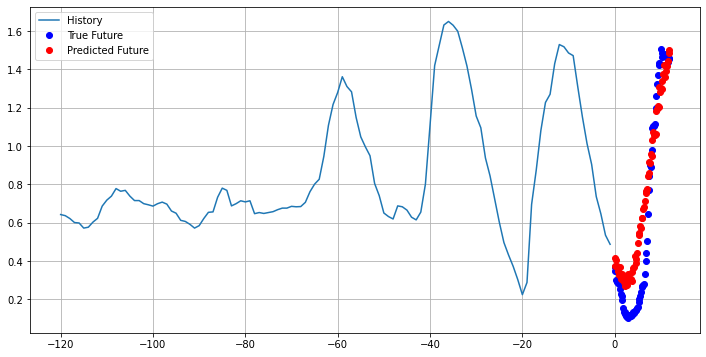

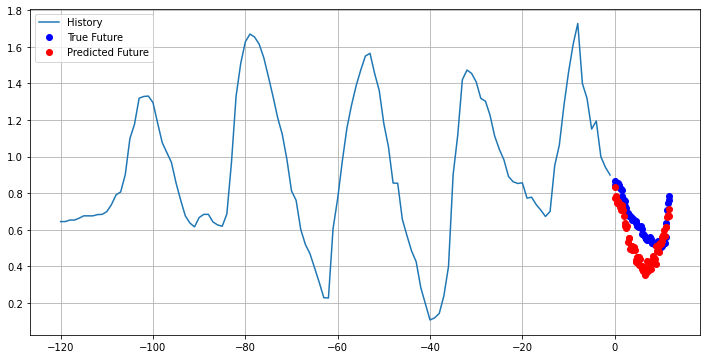

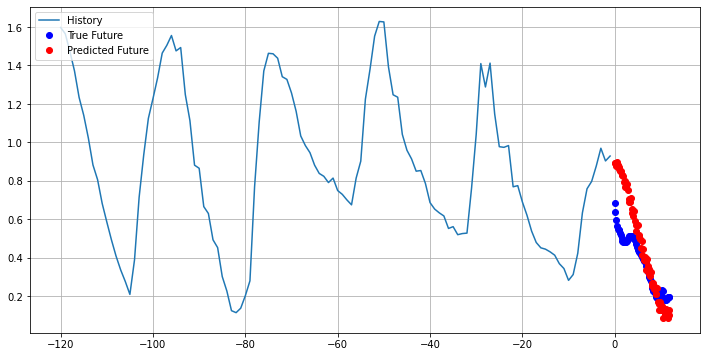

In [89]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])